# Lab 3 — dimensionality reduction

## Setup

In [1]:
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter

from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.mllib.linalg.distributed import RowMatrix, CoordinateMatrix, MatrixEntry

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool

In [2]:
%matplotlib inline
plt.style.use("ggplot")

output_notebook()

sqlContext = SQLContext(sc)

Loading BokehJS ...

In [3]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 5

{"tagId": 1124, "tag": "writing"}
{"tagId": 1125, "tag": "wuxia"}
{"tagId": 1126, "tag": "wwii"}
{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [4]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 5

{"relevance": 0.58775, "tagId": 1124, "movieId": 131170}
{"relevance": 0.010749999999999982, "tagId": 1125, "movieId": 131170}
{"relevance": 0.015749999999999986, "tagId": 1126, "movieId": 131170}
{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


In [5]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
dataS = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

## Exercise 3.1

In [6]:
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())
tagIds = data.map(lambda x: int(x["tagId"]))
M = tagIds.max()

In [7]:
movieIds = dataS.map(lambda x: int(x["movieId"])).distinct()
N = movieIds.count()

In [8]:
scores = dataS.map(lambda r: Row(movieId=r.get("movieId"), tagId=r.get("tagId"), relevance=r.get("relevance")))
schemaScores = sqlContext.createDataFrame(scores)
schemaScores.registerTempTable("scores")

In [9]:
mat = CoordinateMatrix(dataS.map(lambda r: 
        MatrixEntry(r.get("movieId"), r.get("tagId"), r.get("relevance"))))

rm = mat.toRowMatrix()

m = mat.numRows()
n = mat.numCols()

In [10]:
rows = rm.rows

In [11]:
#print(m)
#print(n)

#print(rm.numRows())
#print(rm.numCols())

#print(M)
#print(N)
#print(dataS.count())

In [12]:
dM = np.empty((M, N))

for i, row in enumerate(rows.collect()):
    for j in range(1, 1129):
        dM[j-1, i] = row[j]

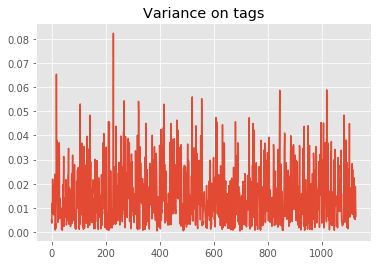

In [13]:
variances = dM.var(axis=1)
plt.plot(variances)
plt.title("Variance on tags")
plt.show()

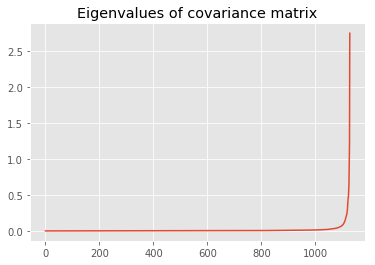

In [14]:
cov_mat = np.cov(dM)
eig_val, eig_vec = np.linalg.eigh(cov_mat)
plt.plot(eig_val)
plt.title("Eigenvalues of covariance matrix")
plt.show()

In [15]:
print(cov_mat.shape)

(1128, 1128)


In [16]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(len(eig_val))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

## Exercise 3.2

In [17]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(1128,1), eig_pairs[1][1].reshape(1128,1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.00572728 -0.01383799]
 [-0.00478882 -0.01048045]
 [ 0.01246704  0.00278201]
 ..., 
 [ 0.01719115 -0.00551248]
 [-0.01026643 -0.01417361]
 [-0.00137267 -0.00551606]]


In [18]:
transformed = matrix_w.T.dot(dM)
transformed.shape

(2, 10381)

## Exercise 3.3

In [19]:
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")

In [20]:
mvids = sorted(movieIds.collect())
ids = list(map(lambda x: mvids.index(x), map(itemgetter(0), movies)))
projected = transformed[:, ids]

In [21]:
def get_color(x):
    if x < 0.25:
        return "#0000FF"
    elif x < 0.5:
        return "#00FF00"
    elif x < 0.75:
        return "#FF0000"
    else:
        return "#FFFF00"

In [22]:
source = ColumnDataSource(
    data={
        "x": projected[0, :],
        "y": projected[1, :],
        "name": [x[1] for x in movies],
        "color": [get_color(x[2]) for x in movies],
    })
hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

In [23]:
p = figure(plot_width=960, tools=tools)
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)